# LDA Model experiments

The purpose of this notebook is to demonstrate building an LDA model.  Example code is also provide to perform an optimal topic no search.  The actual code for execution can be found in the src/models directory.

# Basic concepts and building blocks for the experiments

## Build dictionaries
**Check this at the end to confirm it is still the same**
This notebook relies on preprocessed emails.  During preprocessing the following are performed **Check Accuracy**:
1. Clears formatting.
1. Removes email addresses and URLs in the bodies
1. Expand contractions
1. Tokenize the body.
1. Lemmatize the tokens
1. Remove stopwords from the tokens.


The preprocessed mails are stored in a JSON format intended to be loaded into the Email_Forensic_Processor class.   However, json can be used directly to load and extract the relevant data. This may be more efficient than loading it into the class.

The first step during model building for LDA is to build dictionaries.  The preprocessing prepared the words of interest,  after which dictionaries are compiled in the form of a Bag of Words (BOW).

In the preprocessing we used two ways to extract tokens.  The first called "common" in the code to follow involves normal extraction by means of regular expressions.  The second called "pos" makes use of Spacy's Part of Speech tagging to extract only:
- Nouns
- Proper Nouns
- Verbs



In [1]:
import os
import re
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import json
from pprint import pprint

from tqdm import tqdm

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

import plotly.graph_objects as go


################ Function definitions ###############
# A helper function which loads the json email and returns it as a dictionary
def loadMail(filename):
    with open (filename, "r") as inputFile:
        return json.load(inputFile)
################ End Function definitions ###############


########## Initialisation Section ##########
# Set the location of the directory used for processing
maildir_path = os.path.join('..','..','data', 'processed', 'maildir')
subdir = os.path.join(maildir_path,'allen-p','_sent_mail') 



# Initialise the Bag of Words lists and text lists.

########## End Initialisation Section ##########


########## Code: Loading Dictionaries #########
def build_dictionaries(subdir, pre_pend_filter = "", limit = 10000):
    # This technique requires dictionaries to fit in available memory.
    # It is good for experimenting, but not for general purpose use if lots of data will be processed.
    bow_docs_common = []
    texts_common = []
    bow_docs_pos = []
    texts_pos = []
    dictionary_common = Dictionary()   # Dictionary based on common words
    dictionary_pos = Dictionary()      # Dictionary based on Part of Speech tagging


    print("Building dictionaries\n")

    # Build a dictionary of all the emails
    count = 0
    for root, dirs, files in os.walk(subdir):
        for file in files:
            if not re.search(r'^\.',file):     #Filter out common files created by the OS
                filename = os.path.basename(file)
                if pre_pend_filter == "" or re.match(pre_pend_filter, filename, flags=re.IGNORECASE) != None:
                    email_file = os.path.join(root,file)
                    #new_mail.initMail(email_file)
                    # Build a dictionary and BOW from common token documents

                    #for key, value in developer.items():
                        #print(key, ":", value)
                    email_dict = loadMail(email_file)
                    texts_common.append(email_dict['body_tokens'])
                    dictionary_common.add_documents([email_dict['body_tokens']])
                    bow_docs_common.append(dictionary_common.doc2bow(email_dict["body_tokens"]))

                    # Build a specialised POS dictionary and BOW
                    texts_pos.append(email_dict["body_pos_tokens"])
                    dictionary_pos.add_documents([email_dict["body_pos_tokens"]])
                    bow_docs_pos.append(dictionary_pos.doc2bow(email_dict["body_pos_tokens"]))

                    if count == limit:
                        break
                    else:
                        count = count + 1
    print("Finished building dictionaries.\n\n")

    print("Number of documents in the BOW corpus: ",len(bow_docs_common))
    print("Number of documents in the POS corpus: ",len(bow_docs_pos))
    
    return bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos 
    
bow_docs_common,dictionary_common,texts_common,_,_,_ = build_dictionaries(subdir)

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  602
Number of documents in the POS corpus:  602


## Build the LDA model

The below code builds the model with a basic LDA model with only two topics.  Determining the number of topics is either a guess, or techniques used later in the notebook.  

In [2]:
### Define a helper function to initialise and train the LDA model #####
### The defaults fix some hyperparameters for the LDA model which can be overwritten #####
def build_LDA_model(dictionary, bow_docs, num_topics = 2, 
              chunksize = 2000, 
              passes = 20, 
              iterations = 400, 
              eval_every = None):

    dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=bow_docs,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every)
    return model



####### Set hyperparameters of the models and initialise the models #####
num_topics_common = 2


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common,num_topics = num_topics_common)


# Report some basics to illustrate the result of training the model
# Print the top topics for subjective evaluation
# Extract the top topics from the models
top_topics_common = model_common.top_topics(bow_docs_common) 
#top_topics_pos = model_pos.top_topics(bow_docs_pos)

print("Common BOW topics")
pprint(top_topics_common)

#print("POS BOW topics")
#pprint(top_topics_pos)

# Compute some statistics on topic coherence
print("Computing topic coherence")
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence_common = sum([t[1] for t in top_topics_common]) / num_topics_common
#avg_topic_coherence_pos = sum([t[1] for t in top_topics_pos]) / num_topics_pos

print('Average topic coherence for common BOW: %.4f.' % avg_topic_coherence_common)
#print('Average topic coherence for POS BOW: %.4f.' % avg_topic_coherence_pos)

Training topics for common model

Common BOW topics
[([(0.007845885, 'please'),
   (0.007284804, 'need'),
   (0.0067756954, 'would'),
   (0.0065216413, 'gas'),
   (0.0055183526, 'project'),
   (0.0051840856, 'get'),
   (0.004943368, 'time'),
   (0.0049397484, 'call'),
   (0.004465658, 'know'),
   (0.0042573973, 'ha'),
   (0.004095634, 'email'),
   (0.004010557, 'price'),
   (0.003934218, 'wa'),
   (0.0037714795, 'week'),
   (0.003657623, 'new'),
   (0.0036354975, 'let'),
   (0.0035061275, 'work'),
   (0.003421909, 'like'),
   (0.0033962065, 'want'),
   (0.0032376794, 'deal')],
  -1.4801282983277242),
 ([(0.012409663, 'loan'),
   (0.011261041, 'cost'),
   (0.011136583, 'would'),
   (0.0060505792, 'power'),
   (0.005538481, 'construction'),
   (0.0050478657, 'unit'),
   (0.004742699, 'land'),
   (0.004470461, 'gas'),
   (0.0044696173, 'wa'),
   (0.004399535, 'ha'),
   (0.0041866987, 'lot'),
   (0.0036682712, 'improvement'),
   (0.003450951, 'price'),
   (0.0033416161, 'state'),
   (0.003

### Interpretation on the LDA model

Each topic consists of keywords with associated wheights.  The higher the weigth of a word, the more it will contribute to classifying a piece of text to belong to the particular topic.  With only two topics selected, where there may be many topics within the corpus, the topics are probably not very accurate.

Topic coherence as it is presented here, still requires further investigation.

## Alternative representation
Below is an alternative representation of some of the words in the topic models. The word sizes are proportional to their weight.  Notice that there is no topic heading. Topic modelling is an unsupervised training model and not deterministic, i.e. running the model twice may group different words or result in different weights assigned to the words in a model.

The visual representation is useful in an "eyeball" approach as to how well the topic words are grouped, and especially useful to determine how well the preprocess has filtered unwanted words.  This will be illustrated later in the Notebook.

Wordcloud of topics for the common dictionary.



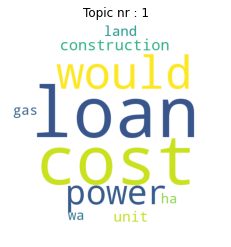

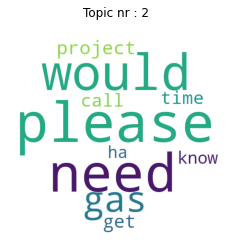

In [4]:
#Define a general helper function to take the trained model and plot a wordcloud of the topics.
def plot_wordcloud(model):
    # Extract the topic words and related frequecies.
    topics = model.show_topics(formatted=False)

    # Define a square mask to print the wordcloud.
    x, y = np.ogrid[:500, :500]
    mask = (x - 250) ** 2 + (y - 250) ** 2 > 250 ** 2
    mask = 255 * mask.astype(int)

    # For each topic, extract the word and frequencies, build a wordcloud and display it.
    for topic_nr,topic in zip(range(0,len(topics)),topics):
        topic_words = dict(topic[1])
        cloud = WordCloud(mask=mask,background_color="white").generate_from_frequencies(topic_words)
        plt.figure()
        plt.imshow(cloud)
        plt.axis("off")
        plt.title("Topic nr : " + str(topic_nr + 1))
        plt.show()

print("Wordcloud of topics for the common dictionary.\n")
plot_wordcloud(model_common)



## Conducting a search for the number of topics

Topic coherence is used to conduct a search for the number of topics.  %Still need to study this in more detail%.
The basic idea is keeping the model hyperparameters fixed, and iterating through the number of topics.  The lower limit and step can be adjusted as required.  Plotting a graph of the scores makes it easier to evaluate the performance of the model across topics.


100%|██████████| 49/49 [08:43<00:00, 10.67s/it]


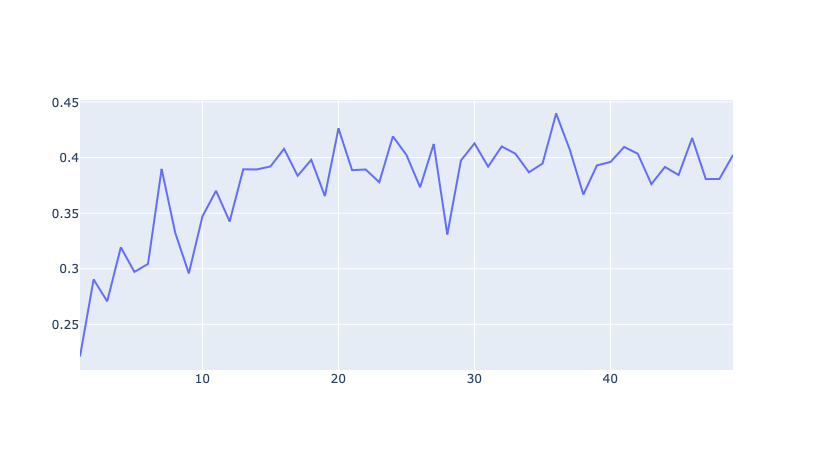

In [5]:
# Helper function to score topics in a range and retain the models in memory
def score_topics(dictionary, bow_docs, texts, start=1, stop=2, step=1, show_progress = True):

    scores = []
    num_topics_list = list(range(start,stop))   # Build a list of integers from start to stop
    num_topics_subset = num_topics_list[::step] # Pick the subset with step size
    
    with tqdm(total=len(num_topics_subset)) as pbar:
        for num_topics in num_topics_subset:
            model = build_LDA_model(dictionary, bow_docs, num_topics)   #Build the model
            coherence_model_lda = CoherenceModel(model=model, texts = texts, 
                                                 dictionary = dictionary, 
                                                 coherence='c_v')       # Build the coherence model
            coherence_lda = coherence_model_lda.get_coherence()         # Get the coherence score
            scores.append((num_topics, coherence_lda, model))           # Save the coherece score with the associated number of topics
            pbar.update(1)
        
    return scores

# Helper function which uses plotly to plot the scores
def plot_topic_scores(scores):
    x = []
    y = []

    # Extract the scores as x,y pairs
    for entry in scores:
        x.append(entry[0])
        y.append(entry[1])

    fig = go.Figure(data=go.Scatter(x=x, y=y))
    fig.show()


 
    
common_scores = score_topics(dictionary_common, bow_docs_common, texts_common, stop = 50)
    
plot_topic_scores(common_scores)        

### Interpretation

The graph above varies.  By hovering over a point, the exact score can be seen.  A similar score exist for 8 and 17 topics.  Plotting wordclouds for some chosen points may provide more insight into what is happening.

No of topics:  7 




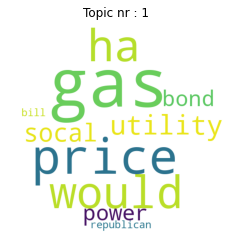

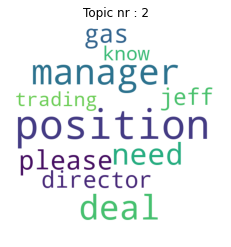

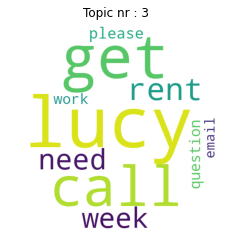

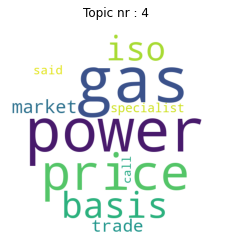

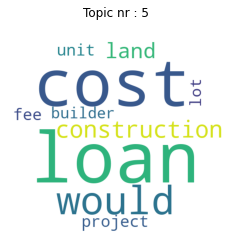

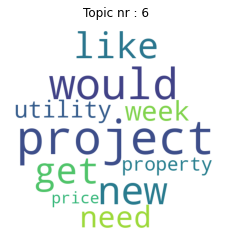

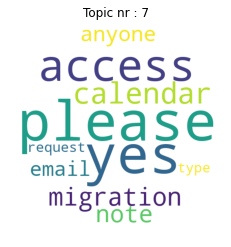


-------------------

No of topics:  20 




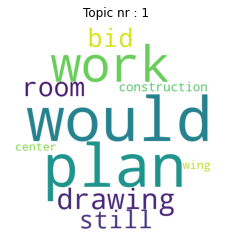

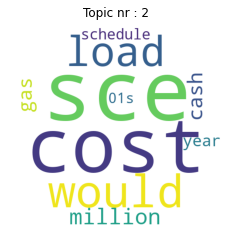

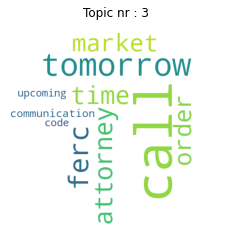

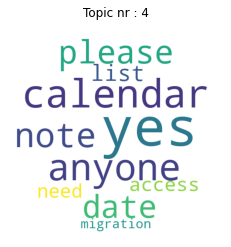

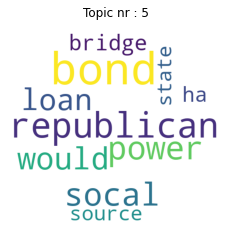

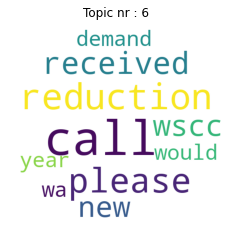

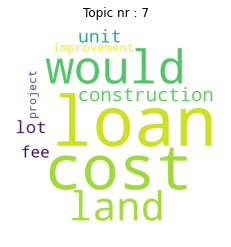

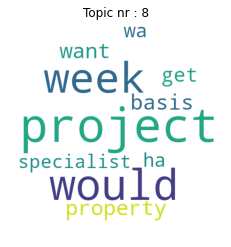

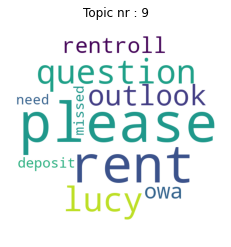

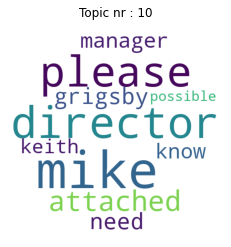


-------------------



In [6]:
plot_list = [7,20]

for nr_topics in plot_list:
    print("No of topics: ",nr_topics,"\n\n")
    plot_wordcloud(common_scores[nr_topics - 1][2])
    print('\n-------------------\n')


It is very difficult to assess based on the above.  For now, the only advantage is that there is a way to select number of topics from a graph.

# Experimenting with pre-processing for optimisation

For the purposes of experimenting with pre-processing, a seperate directory "experimental_data" was created.  Files pre-processed in this directory has different pre_pend strings to the names:
1. Basic_: Only basic pre-processing was performed.
1. Mailer_ : The javamailer style email addresses were filtered out.
1. Name_ : The name of the person who the mails belong to was filtered out.

Each pre-process includes the previous pre_processes filters.  For the basic experiments we fix the number of topics at 10 (an arbitratruy choice), and use wordclouds to subjectively assess the quality of the pre-processing by considering how well the words group together, and how many words we spot which are clearly not supposed to be used in topic classification.

## Basic pre_processing


Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  602
Number of documents in the POS corpus:  602
Training topics for common model

Wordcloud of topics for the basic pre-processing.



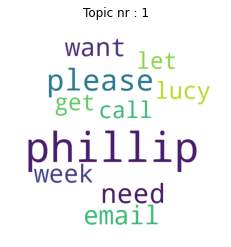

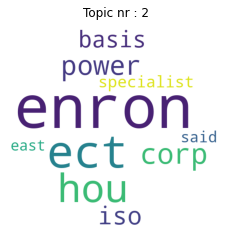

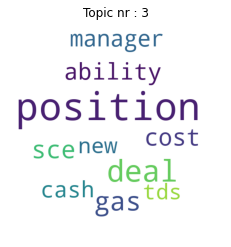

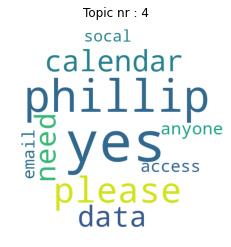

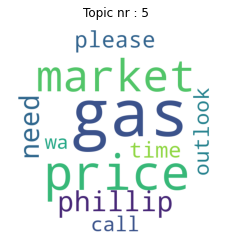

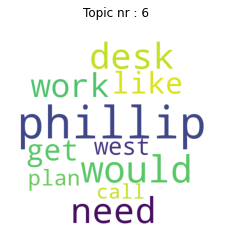

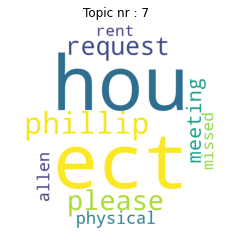

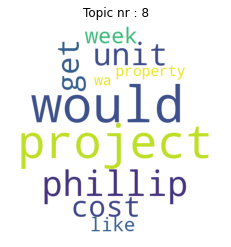

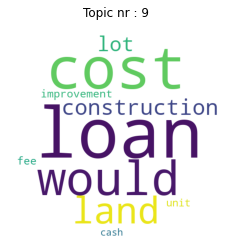

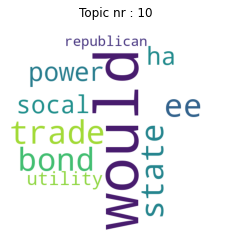

In [7]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','_sent_mail')

bow_docs_common,dictionary_common,texts_common,_,_,_ = build_dictionaries(subdir, pre_pend_filter = "Basic_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 10


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing.\n")
plot_wordcloud(model_common)


It is clear from the wordclouds that "ECT", "HOU" and "Enron" dominate many of the topics.   Upon closer inspection of the actual emails, these terms occur in the email address format used by the javamailer.  This type of information is of no consequence and should be removed.

## Filtering out the javamailer addresses

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  602
Number of documents in the POS corpus:  602
Training topics for common model

Wordcloud of topics for the basic pre-processing.



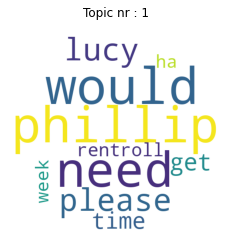

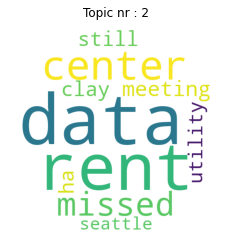

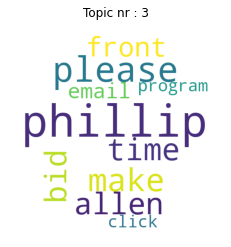

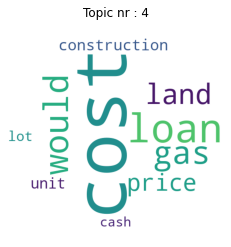

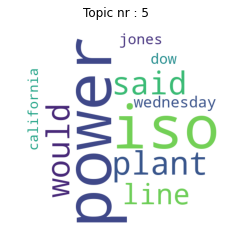

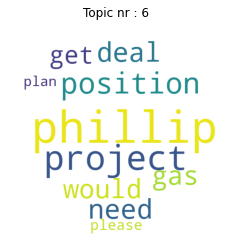

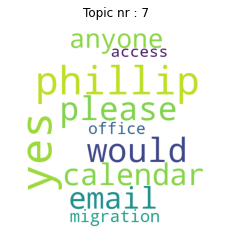

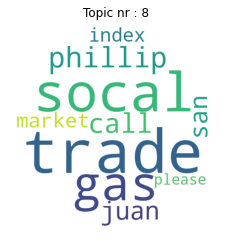

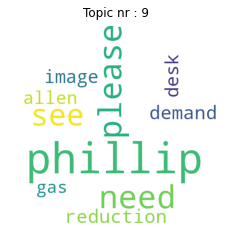

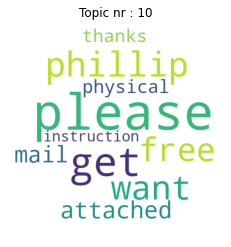

In [9]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','_sent_mail')

bow_docs_common,dictionary_common,texts_common,_,_,_ = build_dictionaries(subdir, pre_pend_filter = "Mailer_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 10


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing.\n")
plot_wordcloud(model_common)



Notice that the mailbox owner name and surname tend to dominate.  This is probably due to the mailbox owner's name or surname appear in his message signature, as this is the sent mail doirectory of Phillap Allen.  We expect something similar to happen in for instance the "all_documents" folder.

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  628
Number of documents in the POS corpus:  628
Training topics for common model

Wordcloud of topics for the basic pre-processing.



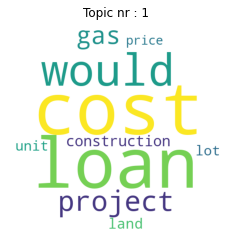

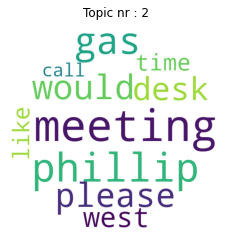

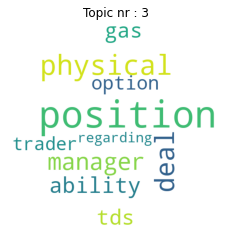

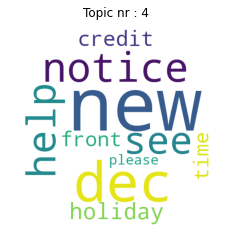

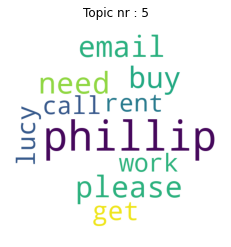

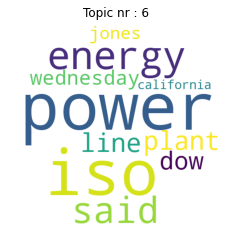

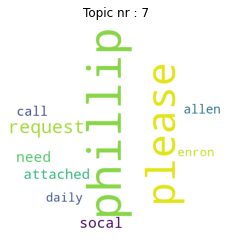

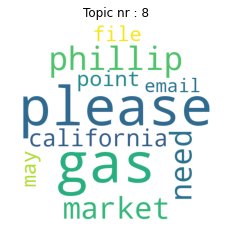

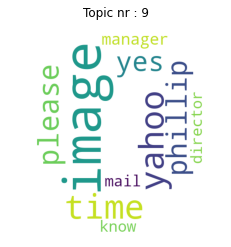

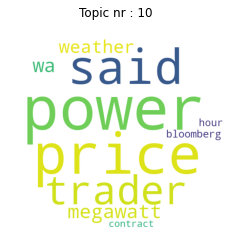

In [12]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','all_documents')

bow_docs_common,dictionary_common,texts_common,_,_,_ = build_dictionaries(subdir, pre_pend_filter = "Mailer_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 10


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing.\n")
plot_wordcloud(model_common)




It seems necessary to filter out the name of the mailbox owner, which is the next filter that we apply.

## Filtering the mailbox owner name

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  602
Number of documents in the POS corpus:  602
Training topics for common model

Wordcloud of topics for the basic pre-processing.



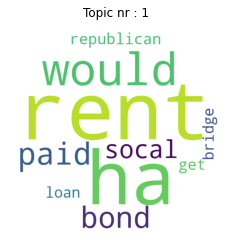

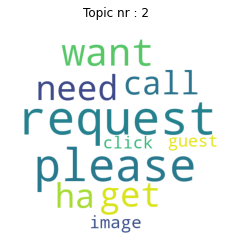

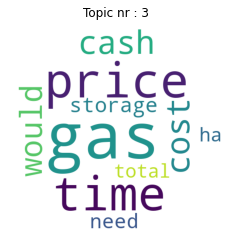

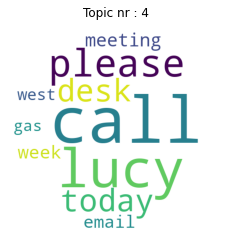

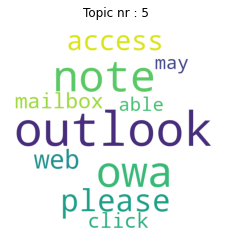

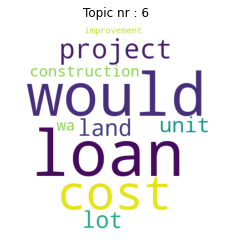

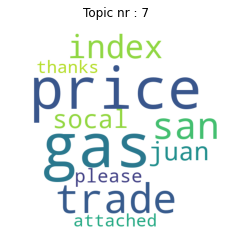

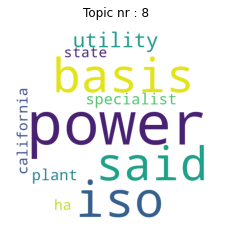

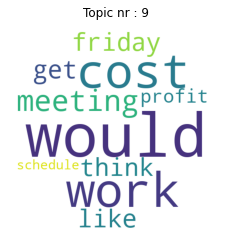

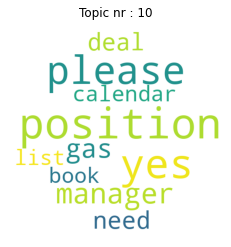

In [13]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','_sent_mail')

bow_docs_common,dictionary_common,texts_common,_,_,_ = build_dictionaries(subdir, pre_pend_filter = "Name_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 10


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing.\n")
plot_wordcloud(model_common)

The topics visually seem to be improving in terms of word groupings.  To confirm, we repeat this for the "all_documents" folder as well.

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  628
Number of documents in the POS corpus:  628
Training topics for common model

Wordcloud of topics for the basic pre-processing.



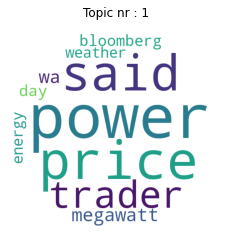

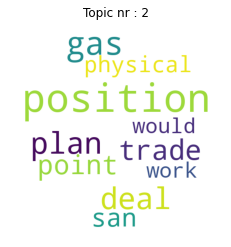

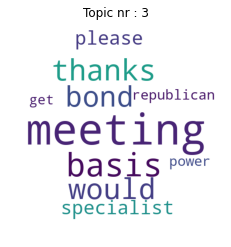

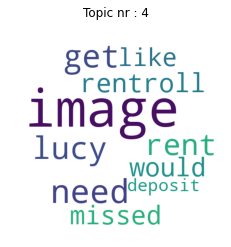

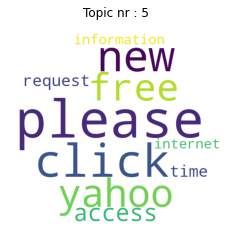

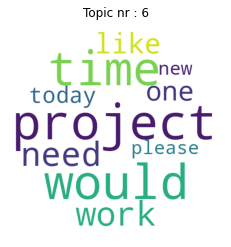

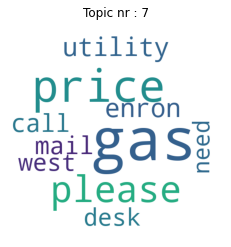

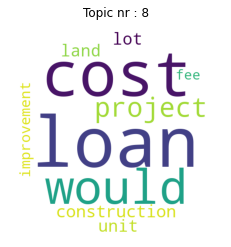

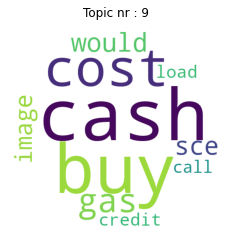

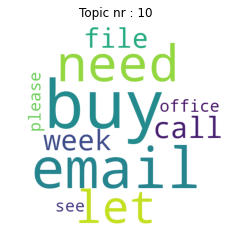

In [14]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','all_documents')

bow_docs_common,dictionary_common,texts_common,_,_,_ = build_dictionaries(subdir, pre_pend_filter = "Name_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 10


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing.\n")
plot_wordcloud(model_common)



_________________________________________________________
# End Notebook
________________


## Special experimentation section

In the section below we perform general experiments with code.  This will be deleted in the final notebook.

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  602
Number of documents in the POS corpus:  602
Training topics for common model

Wordcloud of topics for the basic pre-processing.



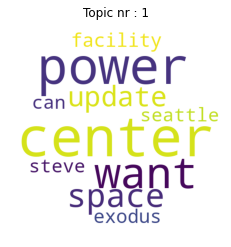

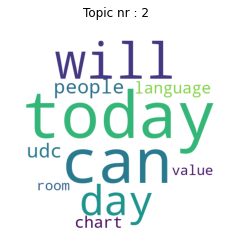

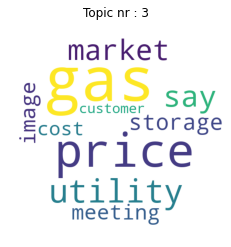

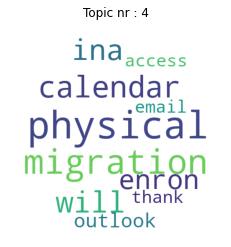

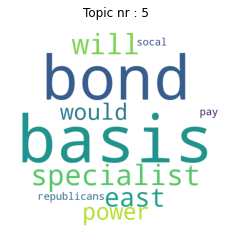

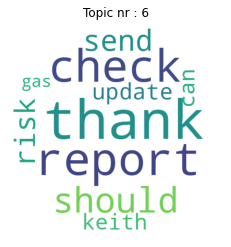

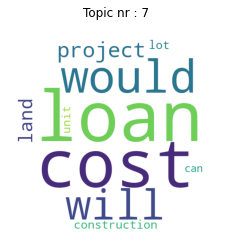

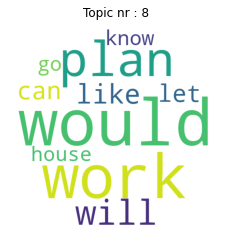

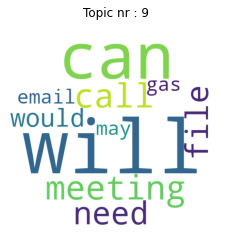

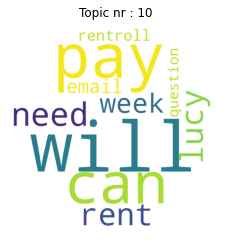

Dictionary(3465 unique tokens: ['address', 'know', 'mailing', 'merlin', 'return']...)


In [40]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','_sent_mail')

_,_,_,bow_docs_common,dictionary_common,texts_common = build_dictionaries(subdir, pre_pend_filter = "Name_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 18


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing.\n")
plot_wordcloud(model_common)

print(dictionary_common)